# Script to Extract Climate Model and Observational Data for Comparison
**Input Data:** Climate and Observational Data  
**Output Data:** Climate and Observational data for a specific variable and spatial extent  
**Description:** Extracts data for a specific variable and spatial extent and exports them to a new file.  
**Date:** June 2022  
**Creator:** Emma Perkins  
**Updated:** April 2023 by Teagan King  
**Note:** It is recommended to run this notebook with 50GB memory allocation.

In [13]:
# import relevant packages
import xarray as xr
import glob
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

In [2]:
# parameters for dask optimization
nworkers = 20
chunk_time = 73
chunk_lat = 100
chunk_lon = 100
nmem='30'
user='tking'

In [3]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem+'GiB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/tking', # Use your local directory
    log_directory='/glade/scratch/tking',
    resource_spec='select=1:ncpus=1:mem='+nmem+'GB', # Specify resources
    account='P93300065', # Input your project ID here, previously this was known as 'project', now is 'account'
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(nworkers)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.61:35687,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load Full Data

In [5]:
%%time

# full observational data
obs_paths = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/*/'  # change to your paths
obs_names = 'e5.oper.an.sfc.128_167_2t.ll025sc.*.nc'  # change to your files, currently reading in ERA5 2-meter air temp
obs_files = sorted(glob.glob(obs_paths+obs_names))
obs_data = xr.open_mfdataset(obs_files, concat_dim=None, parallel=True, chunks={"time":chunk_time, "lat":chunk_lat, "lon":chunk_lon}) 

# full climate model data
clim_path = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/ice/proc/tseries/daily/hs_d/'  # change to your paths
clim_file1 = clim_path+'b.e11.B1850C5CN.f09_g16.005.cice.h1.hs_d_nh.19000101-19991231.nc'  # change to your files
clim_file2 = clim_path+'b.e11.B1850C5CN.f09_g16.005.cice.h1.hs_d_nh.20000101-20991231.nc'
clim_files = [clim_file1, clim_file2]
clim_data = xr.open_mfdataset(clim_files, concat_dim=None, parallel=True, chunks={"time":chunk_time, "lat":chunk_lat, "lon":chunk_lon})

CPU times: user 4.4 s, sys: 422 ms, total: 4.83 s
Wall time: 14.2 s


### Select Variable of Interest

In [6]:
clim_var = 'hs_d'  # change to variable of interest from climate model data
clim_select = clim_data[clim_var]

obs_var = 'VAR_2T'  # change to variable of interest from observational data
obs_select = obs_data[obs_var]

### Modify Lat Lon Coordinates

In [7]:
print(clim_select)

<xarray.DataArray 'hs_d' (time: 73000, nj: 104, ni: 320)>
dask.array<concatenate, shape=(73000, 104, 320), dtype=float32, chunksize=(73, 104, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1900-01-02 00:00:00 ... 2100-01-01 00:00:00
    TLON     (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
    TLAT     (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
    ULON     (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    units:          m
    long_name:      grid cell mean snow thickness
    cell_measures:  area: tarea
    comment:        snow volume per unit grid cell area
    cell_methods:   time: mean
    time_rep:       averaged


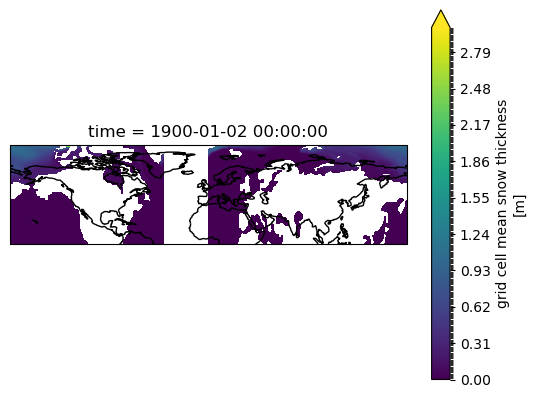

In [17]:
cmap1 = plt.cm.viridis
lev1 = np.arange(0,3.001,0.01)
ax1 = plt.axes(projection=ccrs.PlateCarree())
clim_select.isel(time=0).plot.contourf(cmap = cmap1, levels = lev1, transform=ccrs.PlateCarree())
ax1.coastlines()

# TODO: this projection seems concerning/doesn't line up with underlying data...

In [18]:
float(clim_select.isel(time=0)[75][75])

nan

### Select Area of Interest

In [19]:
# determine variable names
obs_lat_var = 'latitude'  # name of latitude variable for observational data
clim_lat_var = 'TLAT'  # name of latitude variable for climate data
obs_lon_var = 'longitude'  # name of longitude variable for observational data
clim_lon_var = 'TLON'  # name of longitude variable for climate model data

# rename lat lon variables to all be lat lon
obs_select = obs_select.rename({obs_lat_var: 'lat', obs_lon_var: 'lon'})
clim_select = clim_select.rename({clim_lat_var: 'lat', clim_lon_var: 'lon'})

In [20]:
clim_select.lat

<xarray.DataArray 'lat' (nj: 104, ni: 320)>
dask.array<where, shape=(104, 320), dtype=float32, chunksize=(104, 320), chunktype=numpy.ndarray>
Coordinates:
    lon      (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
    lat      (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
    ULON     (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    long_name:  T grid center latitude
    units:      degrees_north
    bounds:     latt_bounds

In [22]:
# TODO: fix sort by latitude (not 1D array):
# obs_select = obs_select.sortby('lat')
# clim_select = clim_select.sortby('lat')

In [24]:
obs_lon_type = 'long3'  # observational longitude coordinate type (long1 or long3)
clim_lon_type = 'long3'  # climate model longitude coordinate type (long1 or long3)
if clim_lon_type == 'long3':
    clim_lon_new = (clim_select.lon + 180) % 360 - 180
    clim_select['lon'] = clim_lon_new
if obs_lon_type == 'long3':
    obs_lon_new = (obs_select.lon + 180) % 360 - 180
    obs_select['lon'] = obs_lon_new

In [25]:
# TODO: fix sortby lon (not 1D array):
# clim_select = clim_select.sortby('lon')
# obs_select = obs_select.sortby('lon')

In [27]:
# select input area from left to right / west to east:
lat_min = 50  # minimum latitude
lat_max = 90  # maximum latitude
lon_min = 150  # minimum longitude
lon_max = -100  # maximum longitude
max_val = 180 # TODO: these next two values cause index failures, 100 and -80 worked
min_val = -180

if lon_min < lon_max:
    obs_select = obs_select.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
    clim_select = clim_select.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
else:
    obs_select1 = obs_select.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, max_val))
    obs_select2 = obs_select.sel(lat=slice(lat_min, lat_max), lon=slice(min_val, lon_max))
    obs_select = xr.concat([obs_select1, obs_select2], dim='lon')

    # clim_select1 = clim_select.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, max_val))
    # clim_select2 = clim_select.sel(lat=slice(lat_min, lat_max), lon=slice(min_val, lon_max))
    # clim_select = xr.concat([clim_select1, clim_select2], dim='lon')

In [30]:
clim_select

<xarray.DataArray 'hs_d' (time: 73000, nj: 104, ni: 320)>
dask.array<concatenate, shape=(73000, 104, 320), dtype=float32, chunksize=(73, 104, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1900-01-02 00:00:00 ... 2100-01-01 00:00:00
    lon      (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
    lat      (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
    ULON     (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(104, 320), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    units:          m
    long_name:      grid cell mean snow thickness
    cell_measures:  area: tarea
    comment:        snow volume per unit grid cell area
    cell_methods:   time: mean
    time_rep:       averaged

In [ ]:
# TODO: fix sortby lon (not 1D array):
# clim_select = clim_select.sortby('lon')
# obs_select = obs_select.sortby('lon')

### Standardize Time Step

In [33]:
%%time

analysis_time_type = '1D'  # time step for analysis (ex: 3H, 1D, 1M, 1Y, etc.)

obs_select = obs_select.resample(time=analysis_time_type).sum('time')
# clim_select = clim_select.resample(time=analysis_time_type).sum('time')

CPU times: user 1min 17s, sys: 3.21 s, total: 1min 20s
Wall time: 1min 28s


In [34]:
# clim_select = clim_select * 86400
# clim_select = clim_select.rename('TP')

### Export Data

In [36]:
obs_outpath = '/glade/scratch/{}/era5/'.format(user)  # path for new observational data file
clim_outpath = '/glade/scratch/{}/cesm/'.format(user)  # path for new climate model data file
obs_name = 'era5_t2m_1979_2022_1D_MRBplus'  # name for new observational data file
clim_name = 'cesmLE_B1850C5CN_TP_1900_2099_1D_MRBplus'  # name for new climate model data file

In [ ]:
%%time

clim_select.load().to_netcdf(clim_outpath+clim_name+'.nc')

In [37]:
%%time

obs_select.load().to_netcdf(obs_outpath+obs_name+'.nc')

CPU times: user 4min 34s, sys: 3.6 s, total: 4min 37s
Wall time: 5min 4s


In [23]:
cluster.scale(0)